# Attention models for Time Series

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A notebook from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).


## Toy seq2seq task

For a start, have a look at the data produced by the following `gen_data` function.
The task at hand is to predict the output sequence from its corresponding input one.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def make_series(positions, heights, shapes, size):
    series = np.zeros((size, ))
    for p, h, s in zip(positions, heights, shapes):
        if s == "r":
            series[p-5:p+5] = h
        else:
            series[p-5:p] = np.linspace(start=0., stop=h, num=5)
            series[p:p+5] = np.linspace(stop=0., start=h, num=5)
    return series.reshape((-1, 1))
    

def gen_data(n_samples, noise_level=.1):
    inputs, outputs = [], []
    shapes = np.array(["t", "r"] * 2)
    n_shapes = len(shapes)
    
    sz = 100
    region_width = sz // n_shapes
    
    for i in range(n_samples):
        np.random.shuffle(shapes)
        index_high_t = np.random.choice(np.where(shapes == "t")[0], size=1)[0]
        index_high_r = np.random.choice(np.where(shapes == "r")[0], size=1)[0]
        
        base_input_series = np.random.randn(sz, 1) * noise_level
        heights = []
        positions = []
        for idx_shape in range(n_shapes):
            pos = idx_shape * region_width + np.random.randint(low=5, high=region_width - 5)
            height = np.random.rand(1)[0] * 10.
            if idx_shape in [index_high_r, index_high_t]:
                height += 10.
            heights.append(height)
            positions.append(pos)
        input_series = np.random.randn(sz, 1) * noise_level + make_series(positions, heights, shapes, sz)
        
        normalized_heights = np.array(heights)
        for s in ["t", "r"]:
            normalized_heights[shapes == s] = normalized_heights[shapes == s].mean()
        output_series = np.random.randn(sz, 1) * noise_level + make_series(positions, normalized_heights, shapes, sz)
        inputs.append(input_series)
        outputs.append(output_series)
            
    return np.array(inputs), np.array(outputs)

np.random.seed(0)
inputs, outputs = gen_data(1000)
test_inputs, test_outputs = gen_data(10)

**Question #1.** Visualize the first 6 input/output pairs (each in one subfigure). Can you guess how the height of output motifs is computed?
Why would this data better suited to attention-based models than convolutional ones, for example?

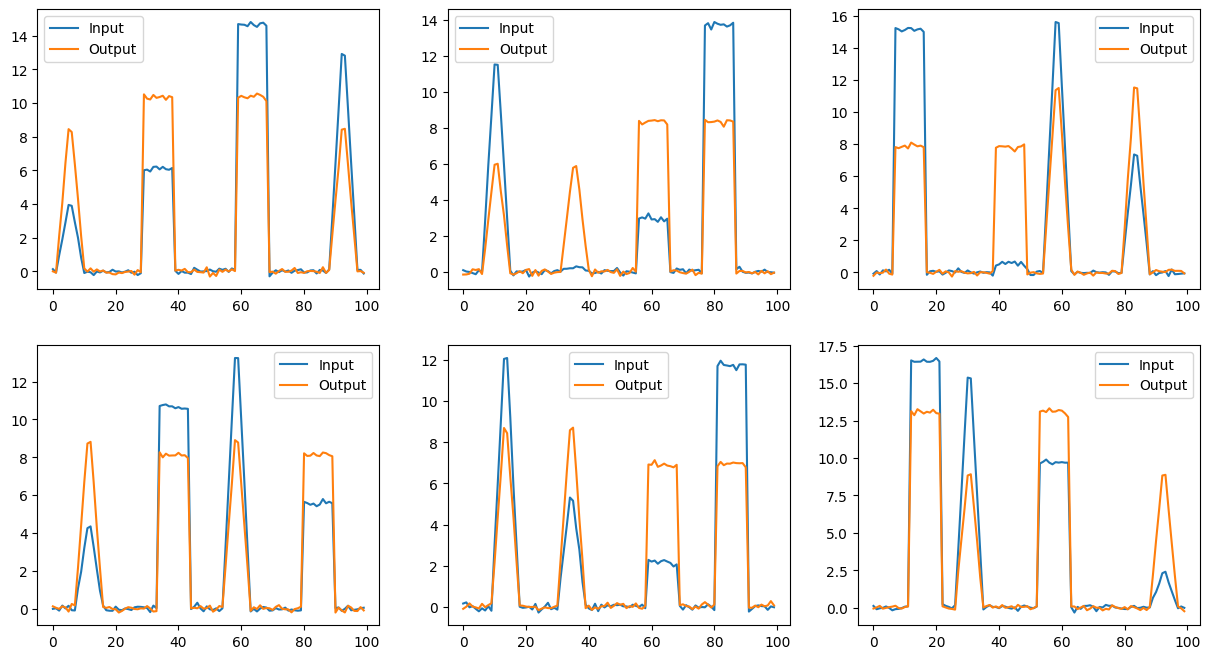

In [2]:
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(inputs[i, :, 0], label="Input")
    plt.plot(outputs[i, :, 0], label="Output")
    plt.legend();

**Question #2.** Check how a model made of a stack of 5 convolutional layers (use 64 filters in all layers except the last one) performs on this task. What loss function should you use?

In [3]:
from keras.models import Sequential
from keras.layers import Conv1D

conv_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=1, kernel_size=5, activation="relu", padding="same")
])
conv_model.compile(optimizer="adam", loss="mse")
h_conv = conv_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=100)

Epoch 1/100


2024-01-18 22:05:01.578732: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-01-18 22:05:01.578753: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-18 22:05:01.578756: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-18 22:05:01.578786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-18 22:05:01.578801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-18 22:05:01.925501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 22:05:02.084350

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 12.6785 - val_loss: 6.5998
Epoch 2/100
 4/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.2615

2024-01-18 22:05:03.516202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6405 - val_loss: 4.2517
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.8763 - val_loss: 2.8932
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.9642 - val_loss: 2.7167
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6090 - val_loss: 2.3019
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5061 - val_loss: 2.1014
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3497 - val_loss: 1.9755
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2949 - val_loss: 2.0610
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2621 - val_loss: 1.9086
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1606 - val_loss: 2.2459
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1797 - val_loss: 1.9475
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1232 - val_loss: 1.9145
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.

**Question #3.** Below is the definition of a multi-head self attention layer class. Use this class to replace the 3rd convolution in your model above by a **single-head self-attention layer** that would output a 64-dimensional time series.

In [4]:
from keras.layers import MultiHeadAttention

class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, num_heads, key_dim, dropout=0.):
        super().__init__(num_heads, key_dim, dropout=dropout)
    
    def build(self, x_shape):
        return super().build(query_shape=x_shape, value_shape=x_shape)
    
    def compute_output_shape(self, x_shape):
        return super().compute_output_shape(query_shape=x_shape, value_shape=x_shape)

    def call(self, x, return_attention_scores=False):
        return super().call(x, x, return_attention_scores=return_attention_scores)
    
att_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    MultiHeadSelfAttention(num_heads=1, key_dim=65),
    Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"),
    Conv1D(filters=1, kernel_size=5, activation="relu", padding="same")
])
att_model.compile(optimizer="adam", loss="mse")
h_att = att_model.fit(inputs, outputs, validation_data=(test_inputs, test_outputs), epochs=100)

Epoch 1/100


2024-01-18 22:06:01.317568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 22:06:01.532346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 18.5900 - val_loss: 4.2542
Epoch 2/100
 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.7830

2024-01-18 22:06:03.794543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.2091 - val_loss: 2.7288
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.1426 - val_loss: 2.6997
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.8394 - val_loss: 2.2671
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.5988 - val_loss: 2.1721
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.5976 - val_loss: 1.8186
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2548 - val_loss: 1.6482
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1381 - val_loss: 1.6482
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0860 - val_loss: 1.6478
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0899 - val_loss: 2.1158
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.1968 - val_loss: 1.4955
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9902 - val_loss: 1.5034
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.

**Question #4.** Compare both models in terms of validation loss.

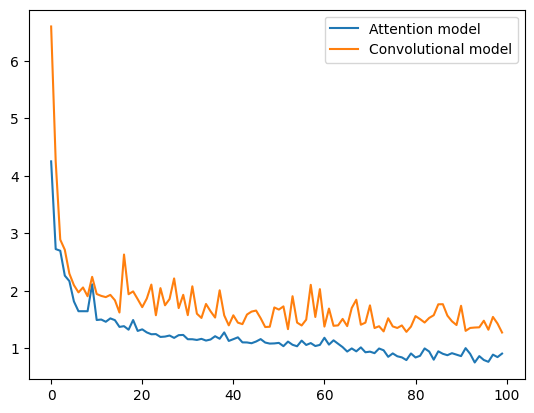

In [5]:
plt.plot(h_att.history["val_loss"], label="Attention model")
plt.plot(h_conv.history["val_loss"], label="Convolutional model")
plt.legend();

**Question #5.** Use test data for qualitative inspection of the produced outputs.

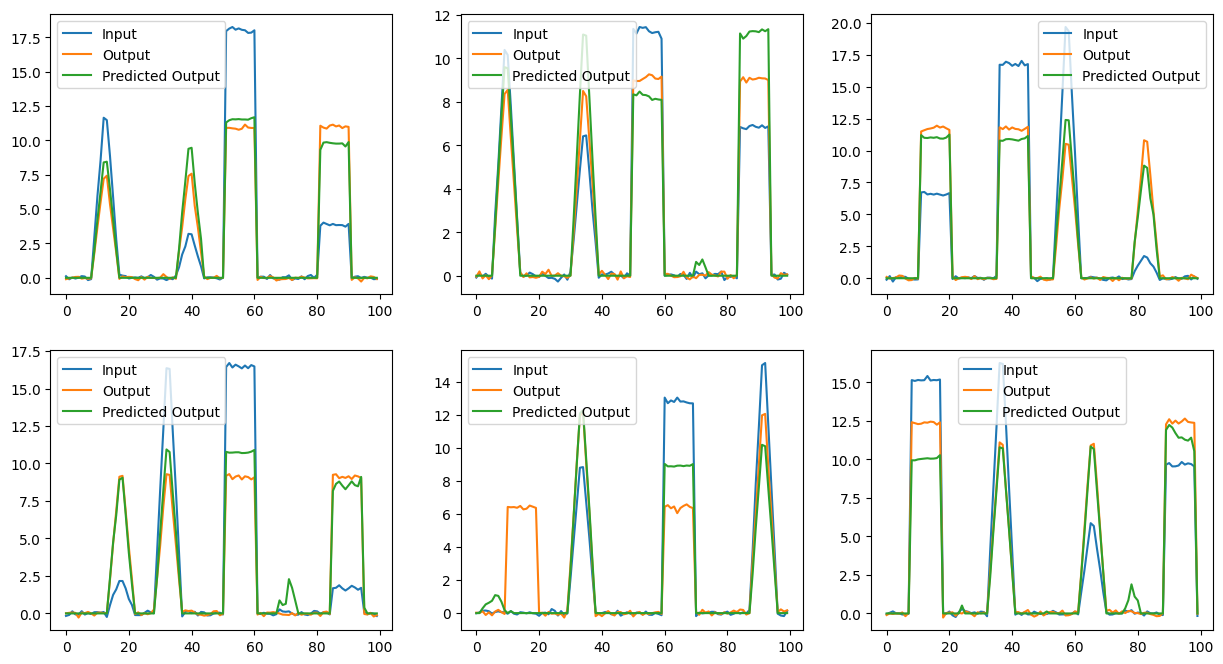

In [6]:
preds = conv_model(test_inputs)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], label="Input")
    plt.plot(test_outputs[i, :, 0], label="Output")
    plt.plot(preds[i, :, 0], label="Predicted Output")
    plt.legend();

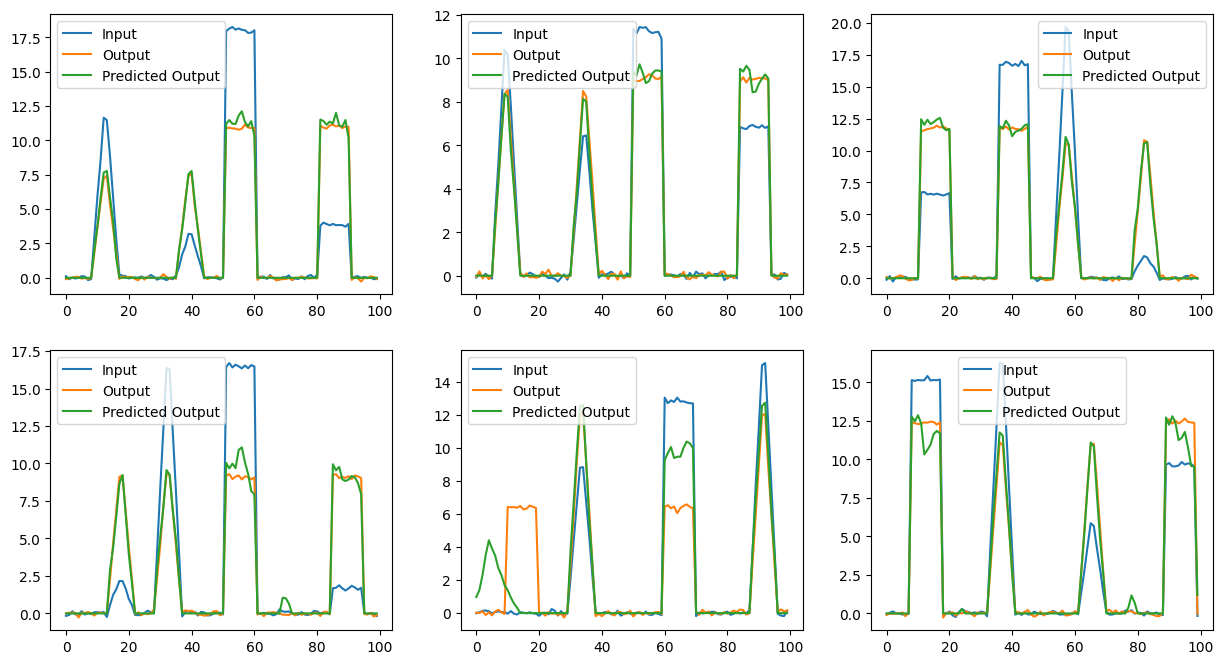

In [7]:
preds = att_model(test_inputs)

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.plot(test_inputs[i, :, 0], label="Input")
    plt.plot(test_outputs[i, :, 0], label="Output")
    plt.plot(preds[i, :, 0], label="Predicted Output")
    plt.legend();

**Question #6.** Use the code below to visualize average attention scores for the first 3 test series.

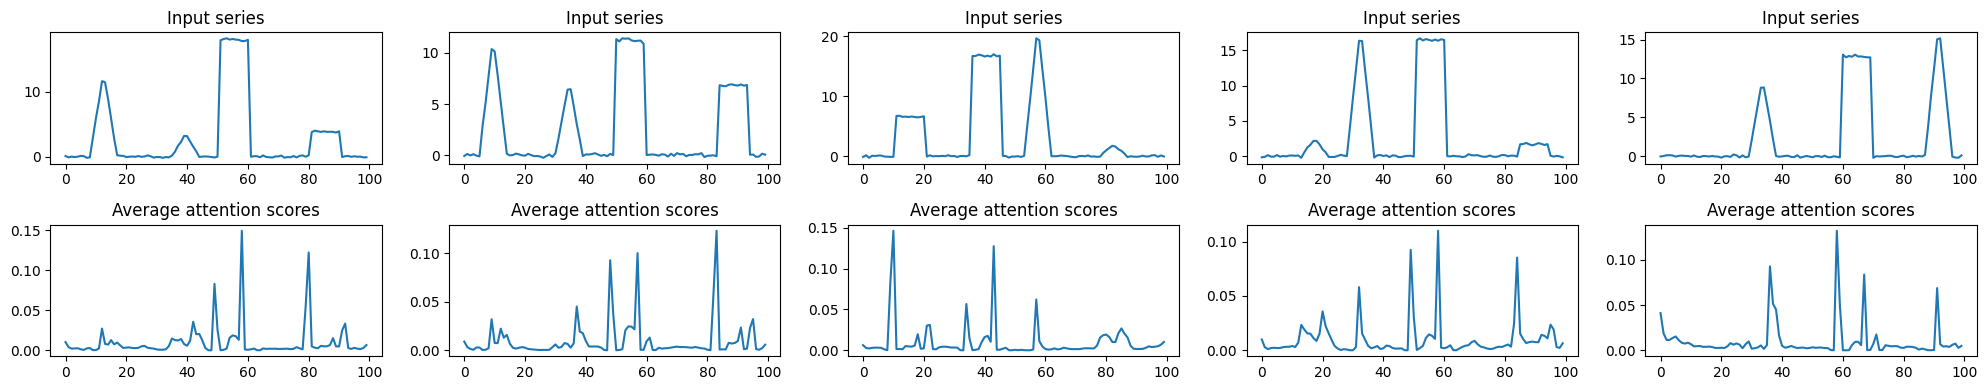

In [8]:
from keras.models import Sequential

def visualize_average_attention_scores(model, index_of_attention_layer, time_series):
    sub_model = Sequential(model.layers[:index_of_attention_layer])
    input_features = sub_model(time_series)
    att_layer = model.layers[index_of_attention_layer]
    output_tensor, weights = att_layer(input_features, return_attention_scores=True)

    plt.figure(figsize=(4*len(time_series), 4))
    for idx, ts in enumerate(time_series):
        plt.subplot(2, len(time_series), idx + 1)
        plt.plot(ts.ravel())
        plt.title("Input series")
        plt.subplot(2, len(time_series), len(time_series) + idx + 1)
        plt.plot(weights[idx, 0].numpy().mean(axis=0))
        plt.title("Average attention scores")
    plt.tight_layout()

visualize_average_attention_scores(att_model, index_of_attention_layer=2, time_series=test_inputs[:5])

## Attention models for Time Series Classification

In this section, you will design a model that relies on attention for the Trace dataset you already used in previous labs.

**Question #7.** Load the Trace dataset, merge training and test data and shuffle the resulting dataset.

In [9]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

y_train -= 1
y_test -= 1

X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

indices = np.random.choice(len(X), size=len(X), replace=False)
X = X[indices]
y = y[indices]

print(X.shape, y.shape)

(200, 275, 1) (200,)


**Question #8.** Using only convolutions, self-attention and dense layers, design a first neural network architecture for the task at hand. You will use 20% of the data as validation (see the `validation_split` argument of the `model.fit` function).

In [10]:
from keras.layers import Dense, Flatten, MaxPool1D

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    MultiHeadSelfAttention(num_heads=6, key_dim=64),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(4, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X, y, validation_split=0.2, epochs=100)

Epoch 1/100


2024-01-18 22:07:56.056673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 22:07:56.277890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1995 - loss: 1.3956

2024-01-18 22:07:59.584958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.1975 - loss: 1.3963 - val_accuracy: 0.2250 - val_loss: 1.3875
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2707 - loss: 1.3871 - val_accuracy: 0.2250 - val_loss: 1.3844
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2244 - loss: 1.3887 - val_accuracy: 0.2750 - val_loss: 1.3805
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3132 - loss: 1.3835 - val_accuracy: 0.4250 - val_loss: 1.3818
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3945 - loss: 1.3770 - val_accuracy: 0.4250 - val_loss: 1.3659
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5010 - loss: 1.3468 - val_accuracy: 0.4250 - val_loss: 1.3011
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4997 - loss: 1.2201 - val_accuracy: 0.4250 - val_loss: 1.0966
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5063 - loss: 0.9310 - val_accuracy: 0.4250 - val_loss: 0.9481
Epo

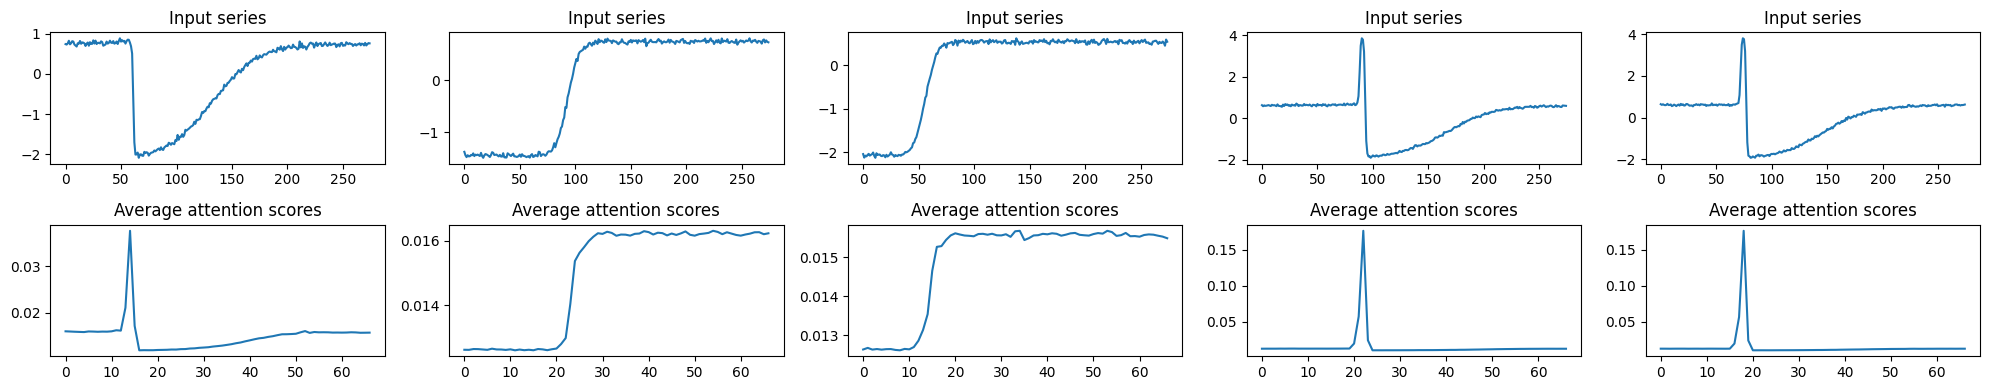

In [11]:
visualize_average_attention_scores(model, index_of_attention_layer=4, time_series=X[:5])

**Question #9.** Sub-class the `Conv1D` layer to implement a residual layer that would compute its output as:

$$\text{ResidualConv}(x) = x + \text{Conv}(x)$$

where $\text{Conv}(x)$ is a 1d convolution applied to the input series $x$.

Why would it make sense to use such a layer in place of a convolutional one?

In [12]:
class ResConv1D(Conv1D):
    def __init__(self, filters, kernel_size, activation="linear"):
        super().__init__(filters, kernel_size, activation=activation, padding="same")

    def call(self, x):
        return x + super().call(x)

**Question #10.** Replace convolutional layers by residual convolutional layers in your previous model and see if performance is improved.

In [13]:
model = Sequential([
    ResConv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    ResConv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    MultiHeadSelfAttention(num_heads=6, key_dim=64),
    ResConv1D(filters=64, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(4, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X, y, validation_split=0.2, epochs=20)

Epoch 1/20


2024-01-18 22:08:31.689433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-18 22:08:31.903973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3413 - loss: 1.3622

2024-01-18 22:08:33.554570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.3500 - loss: 1.3365 - val_accuracy: 0.4250 - val_loss: 0.7006
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6614 - loss: 0.5190 - val_accuracy: 0.7750 - val_loss: 0.3562
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7429 - loss: 0.4307 - val_accuracy: 0.7000 - val_loss: 0.3770
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7243 - loss: 0.4820 - val_accuracy: 0.7750 - val_loss: 0.4592
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7189 - loss: 0.4185 - val_accuracy: 0.7000 - val_loss: 0.3117
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7856 - loss: 0.3157 - val_accuracy: 0.9500 - val_loss: 0.2869
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8587 - loss: 0.2813 - val_accuracy: 0.7750 - val_loss: 0.2414
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9256 - loss: 0.2260 - val_accuracy: 0.9500 - val_loss: 0.1757
Epoch 9/2